# Minimal model implementation

This notebook demonstrates how to implement your own model in `neurolib`. There are two main parts of each model: its class that inherits from the `Model` base class and its `timeIntegration()` function. 

In [5]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-2] == "neurolib":
    os.chdir('..')

%load_ext autoreload
%autoreload 2

In [6]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt

## Model equations

In this example we will implement a linear model with the following equation:

$\frac{d}{dt} x_i(t) = - \frac{x_i(t)}{\tau} + \sum_{j=0}^{N} K G_{ij} x_j(t)$.

Here, we simulate $N$ nodes that are coupled in a network. $x_i$ are the elements of an $N$-dimensional state vector, $\tau$ is the decay time constant, $G$ is the adjacency matrix and $K$ is the global coupling strength.

## Implementation

We first create a class for the model called `LinearModel` which inherits lots of functionality from the `Model` base class. We define `state_vars` and `default_output` so that `neurolib` knows how to handle the variables of the system. Next, we define `init_vars` in order to use the autochunk integration scheme, so we can save a lot of RAM when we run very long simulations. 
```
class LinearModel(Model):
    state_vars = ["x"]
    default_output = "x"
    init_vars = ["x_init"]
```
Next we define a simple parameter dictionary called `params`. In here, we can define all the necessary parameters of the model and change their values later. In this example, we set the timescale $\tau$, the coupling strength $K$, the integration time step `dt` (in ms) and the duration to 100 ms.
```
params = dict(tau=10, K=1e-2, dt=1e-1, duration=100)
```
We are now ready to set up the constructor of our model! This method is supposed to set up the model and prepare it for integration. All the magic happens in the background! We pass the `self.timeIntegration` function and the parameter dictionary `self.params` to the base class using `super().__init__()`.
```
def __init__(self, Cmat=np.zeros((1,1))):
        self.params['Cmat'] = Cmat
        super().__init__(self.timeIntegration, self.params)
```
That wasn't too bad, was it? We are finally ready to define the time integration method that prepares all variables and passes it to the last function that will crunch the numbers. Here we prepare the numpy arrays that will hold the simulation results. We have to prepare them before we can execute the numba code. 

```
def timeIntegration(self, p):
    N = p['Cmat'].shape[0]
    t = np.arange(1, p['duration']/p['dt']) # holds time steps
    x = np.ndarray((N, len(t)+1)) # holds variable x
```
Next, we make use of a neurolib convention to prepare the initial conditions of our model. If you remember, we defined `init_vars` above in order to use the autochunk feature. The autochunk feature will automatically fill this parameter with the last state of the last simulated chunk so the model integration can be continued without having to remember the entire output and state variables of the model indefinitely. In this line, we check whether x_init is set or not (which it will be, when we use chunkwise integration). If it is not set, we simply use random initial conditions using `rand((N, 1))`. Remember that the convention for array dimensions is `array[space, time]`, meaning that we only fill in the first time step with the initial condition. 
```
# either use predefined initial conditions or random ones
x[:, :1] = p.get('x_init') if p.get('x_init') is not None else rand((N, 1))
```
We're ready to call our accelerated integration part and return the results 🚀!
```
return njit_integrate(x, t, p['tau'], p['K'], N, p['Cmat'], p['dt'])
```

## Numba time integration 

Remember to put this function outside of the class definition, so we can use use `numba` acceleration to greatly increase the performance of our code. We first have to let `numba` know which part of the code to precompile. We do this by simply placing the decorator `@numba.njit` in the line above the integration function. Easy way of getting 100x faster code! ❤️ `numba`! 
```
@numba.njit
def njit_integrate(x, t, tau, K, N, Cmat, dt):
```
Next, we do some simple math. We first loop over all time steps. If you have prepared the array `t` as described above, you can simply loop over its length. In the next line, we calculate the coupling term from the model equation above. However, instead of looping over the sum, we use a little trick here and simply compute the dot product between the coupling matrix `G` and the state vector `x`. This results in a `N`-dimensional vector that carries the amount of input each node receives at each time step. Finally, we loop over all nodes so we can finally add up everything.

```
for i in range(1, 1 + len(t)): # loop over time
    inp = Cmat.dot(x[:, i-1]) # input vector
    for n in range(N): # loop over nodes
```
In the next line, we integrate the equation that we have shown above. This integration scheme is called Euler integration and is the most simple way of solving an ODE. The idea is easy and is best expressed as `x_next = x_before + f(x) * dt` where `f(x)` is simply the time derivative $\frac{d}{dt} x_i(t)$ shown above.
```
x[n, i] = x[n, i-1] + (- x[n, i-1] / tau + K * inp[n]) * dt # model equations
```
We're done! The only thing left to do is to return the data so that neurolib can take over from here on. The outputs of this simulation will be available in the `model.outputs` attribute. You can see an example time series below. 
```
return t, x
```

## Code

In [8]:
import numba
import numpy as np
from numpy.random import random as rand
from neurolib.models.model import Model

class LinearModel(Model):
    state_vars = ["x"]
    default_output = "x"
    init_vars = ["x_init"]
    params = dict(tau=10, K=1e-2, dt=1e-1, duration=100)
    def __init__(self, Cmat=np.zeros((1,1))):
        self.params['Cmat'] = Cmat
        super().__init__(self.timeIntegration, self.params)
        
    def timeIntegration(self, p):
        p['N'] = p['Cmat'].shape[0] # number of nodes
        t = np.arange(1, p['duration']/p['dt'] + 1) # holds time steps
        x = np.ndarray((p['N'], len(t)+1)) # holds variable x
        # either use predefined initial conditions or random ones
        x[:, :1] = p['x_init'] if 'x_init' in p else rand((p['N'], 1))
        return njit_integrate(x, t, p['tau'], p['K'], p['N'], p['Cmat'], p['dt'])

@numba.njit
def njit_integrate(x, t, tau, K, N, Cmat, dt):
    for i in range(1, 1 + len(t)): # loop over time
        inp = Cmat.dot(x[:, i-1]) # input vector
        for n in range(N): # loop over nodes
            x[n, i] = x[n, i-1] +\
            (- x[n, i-1] / tau + K * inp[n]) * dt # model equations
    return t, x

## Running the model

We prepare a "mock" connectivity matrix, simply consisting of 12x12 random numbers, meaning that we will simulate 12 `LinearModel`'s in a network.

In [12]:
Cmat = rand((12, 12)) # use a random connectivity matrix
model = LinearModel(Cmat) # initialize the model

That's it, we are finally ready to run the model.

In [10]:
model.run()

## Plot outputs

Text(0, 0.5, 'Activity $x$')

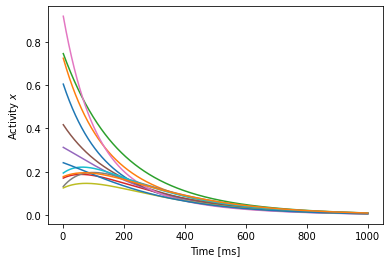

In [11]:
plt.plot(model.t, model.output.T);
plt.xlabel("Time [ms]")
plt.ylabel("Activity $x$")

## BOLD and autochunk

Since we've followed the model implementation guidelines, the model is also compatible with chunkwise integration and can produce a BOLD signal. Let's try it out!

In [73]:
model.params.duration=200000
model.run(chunkwise=True, append_outputs=True, bold=True)

Text(0, 0.5, 'BOLD activity')

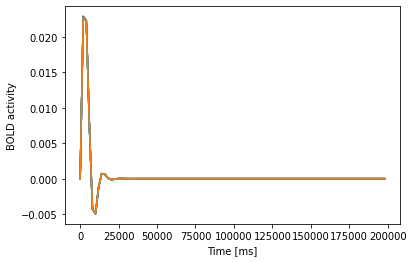

In [75]:
plt.plot(model.BOLD.t_BOLD, model.BOLD.BOLD.T);
plt.xlabel("Time [ms]")
plt.ylabel("BOLD activity")